In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib
from scipy import stats
import copy
from function import confid

import cartopy.crs as ccrs                   # import projections
import cartopy

from scipy.io import loadmat

In [2]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.close('all')

__figdir__ = './figures/'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}

savefig = False # flag to write plots to files
plotswot = False # flag to include plot of SWOT cal/val track

In [3]:
#domain for plotting map
xmin, xmax = (125,290)
ymin, ymax = (-28,61)

In [4]:
# data for fft of running avergaed filtered ssh
path = 'data/fft_filtered_hann_detrend_ssh_14yrs_all_freqs.nc'
nc = Dataset(path,'r')
lon,lat = np.meshgrid(nc.variables['lon'][:],nc.variables['lat'][:])
lon =360*(lon<0)+lon
# Subset to include only frequency band of interest:
fft_h = nc.variables['fftreal'][150:160,:,:] \
       + 1j* nc.variables['fftimg'][150:160,:,:]
N = 1022. # number of data points (use later to normalize fft output)
# the spacing of frequency 
df = nc.variables['cycle_per_day'][1]- nc.variables['cycle_per_day'][0]


# data for fft of 0.1 degree resolution SU,SV (depth-averaged U,V in cm/s)
path2 = 'data/fft_su_hann_33_day.nc'
path3 = 'data/fft_sv_hann_33_day.nc'
nc2 = Dataset(path2,'r')
fft_u = nc2.variables['fft_su_real'][:] \
       + 1j* nc2.variables['fft_su_img'][:]
nc3 = Dataset(path3,'r')
fft_v = nc3.variables['fft_sv_real'][:] \
       + 1j* nc3.variables['fft_sv_img'][:]
R0 = 1.027 # sea water density in g/cm^3
# SU, SV are in unit of cm/s
S_u = np.mean(2.* (np.absolute(fft_u)**2.)/(N**2. * df),axis = 0)
S_v = np.mean(2.* (np.absolute(fft_v)**2.)/(N**2. * df),axis = 0)
#S_ke = 0.5 * R0 *(S_u + S_v) 


#the longitude of coherence reference location, default is 230.
#(the resolution of longitude and latitude is 0.1 deg)
ref_lon =220.0
#the latitude of coherence reference location, default is 5.4.
ref_lat =5.4
#find the location index of the nearest grid
dis = (lon-ref_lon)**2. + (lat-ref_lat)**2.
idx = np.nonzero(dis ==dis.min())

x0 = lon[int(idx[0]),int(idx[1])]
y0 = lat[int(idx[0]),int(idx[1])]

<ipython-input-4-a7bed6e1cb08>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon,lat = np.meshgrid(nc.variables['lon'][:],nc.variables['lat'][:])
<ipython-input-4-a7bed6e1cb08>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fft_h = nc.variables['fftreal'][150:160,:,:] \
<ipython-input-4-a7bed6e1cb08>:7: DeprecationWarning: `np.bool` is a depre

In [5]:
fft_ref = fft_h[:,int(idx[0]),int(idx[1])]
S_ref = np.mean(2.*(np.absolute(fft_ref)**2.)/(N**2. * df),axis = 0)


cp = fft_u*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_u = np.absolute(C_lf)**2./(S_u*S_ref)

cp = fft_v*np.conjugate(fft_ref)[...,np.newaxis,np.newaxis]
C_lf = np.mean(2.*cp/(N**2. * df),axis = 0)
coh_v = np.absolute(C_lf)**2./(S_v*S_ref)

frac = (coh_u*S_u + coh_v*S_v)/ (S_u + S_v)

#Coherence error bar (dof for hann window is considered)
errbar = np.sqrt(1.-(0.05)**(1./( (10/1.9445) -1))) 

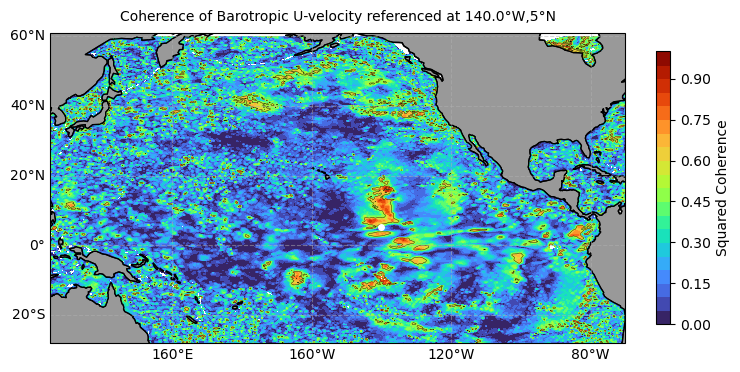

In [6]:
fig = plt.figure()
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Coherence of Barotropic U-velocity referenced at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.contourf(lon,lat,coh_u, levels, transform=ccrs.PlateCarree())
plt.contour(lon,lat,coh_u,[errbar**2.],colors= 'black',linewidths = 0.3, transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Squared Coherence',fontsize = 10)

x0 = lon[int(idx[0]),int(idx[1])]
y0 = lat[int(idx[0]),int(idx[1])]
plt.plot(x0, y0, marker='o',color='white',transform=ccrs.PlateCarree(),markersize = 4);
if savefig:
    plt.savefig(__figdir__+'SU_coher_raw.png',**savefig_args)

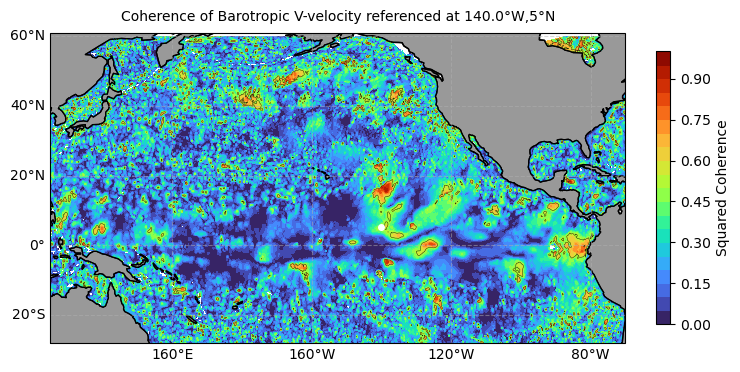

In [7]:
fig = plt.figure()
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Coherence of Barotropic V-velocity referenced at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.contourf(lon,lat,coh_v, levels, transform=ccrs.PlateCarree())
plt.contour(lon,lat,coh_v,[errbar**2.],colors= 'black',linewidths = 0.3, transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Squared Coherence',fontsize = 10)

x0 = lon[int(idx[0]),int(idx[1])]
y0 = lat[int(idx[0]),int(idx[1])]
plt.plot(x0, y0, marker='o',color='white',transform=ccrs.PlateCarree(),markersize = 4);
if savefig:
    plt.savefig(__figdir__+'SV_coher_raw.png',**savefig_args)

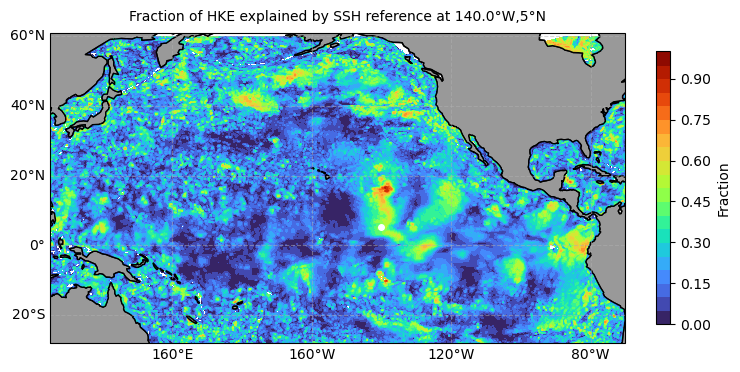

In [8]:
fig = plt.figure()
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of HKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.contourf(lon,lat,frac, levels, transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Fraction',fontsize = 10)

x0 = lon[int(idx[0]),int(idx[1])]
y0 = lat[int(idx[0]),int(idx[1])]
plt.plot(x0, y0, marker='o',color='white',transform=ccrs.PlateCarree(),markersize = 4);
if savefig:
    plt.savefig(__figdir__+'HKE_fraction_raw.png',**savefig_args)

# Reference 2

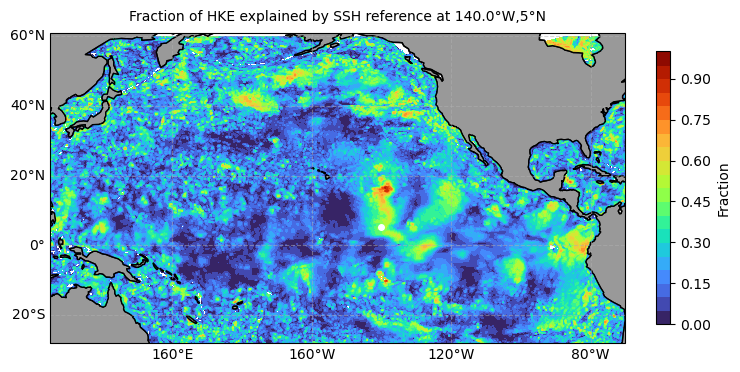

In [9]:
fig = plt.figure()
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of HKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.contourf(lon,lat,frac, levels, transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Fraction',fontsize = 10)

x0 = lon[int(idx[0]),int(idx[1])]
y0 = lat[int(idx[0]),int(idx[1])]
plt.plot(x0, y0, marker='o',color='white',transform=ccrs.PlateCarree(),markersize = 4);
if savefig:
    plt.savefig(__figdir__+'HKE_fraction_raw.png',**savefig_args)

# Reference 3

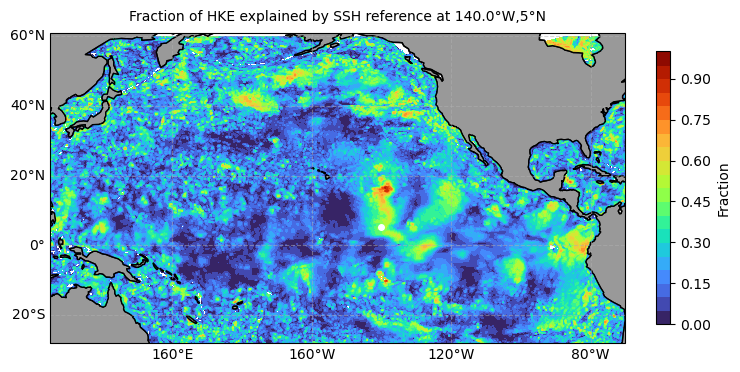

In [10]:
fig = plt.figure()
degree_sign= u'\N{DEGREE SIGN}'
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=200))  # Orthographic
extent = [xmin, xmax, ymin, ymax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.set_title('Fraction of HKE explained by SSH reference at '+\
          str(round(360-x0,1))+degree_sign+'W,'+str(int(y0))+degree_sign+'N',size =10.)

plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.MaxNLocator(10)
# gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(130, 230,10))

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[.6,.6,.6], edgecolor='black')
levels = np.linspace(0,1,21)
cs = ax.contourf(lon,lat,frac, levels, transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('Fraction',fontsize = 10)

x0 = lon[int(idx[0]),int(idx[1])]
y0 = lat[int(idx[0]),int(idx[1])]
plt.plot(x0, y0, marker='o',color='white',transform=ccrs.PlateCarree(),markersize = 4);
if savefig:
    plt.savefig(__figdir__+'HKE_fraction_raw.png',**savefig_args)

## Tom/Roger discussion of next steps

What have we learned so far?
1. Plot above (using 130W, 5N) is very impressive-- 50% (and more) barotropic HKE at very far distances can be associated with TIW
1. However!  Coherence does not prove causation.  The significant coherence in other ocean basins, for example, should give us reason to pause and think more about this.  What about W of Japan?
1. The general correspondence of smoothed model SSH with (smooth) altimetry SSH analyses is interesting
1. The patchy small-scale variability in SSH, coherent with TIWs, is very interesting.

What should we think more about?
1. Should we look into wind-KW-TIW connections? (Tom can elaborate)  It would be easier to investigate if we had surface currents

What should be the next steps? (Brainstorm)
1. [x] Clean up code (make the other SSH notebooks consistent with architecture of this code, e.g., use data and figures folders)
1. [x] More code clean up: add flags for saving plots from Tom's code (from other SSH notebooks)
1. Add "if zoom" flag in cell 3
1. [x] Add modification to make reference point selectable by lat/lon
1. Add all processing code to this directory
1. Ask Frank about surface currents


